In [ ]:
"""
  The code here has been inspired by

  PySpark Cookbook:
  Over 60 recipes for implementing big data processing and analytics using
  Apache Spark and Python
"""

# Machine Learning with Spark MLLib

In [ ]:
!pip install pyspark


In [ ]:
import pyspark
print(pyspark.__version__)


3.5.4


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ColabPySpark") \
    .master("local[*]") \
    .getOrCreate()

print("Spark is running:", spark.version)


Spark is running: 3.5.4


In [ ]:
# # Get Spark context
sc = spark.sparkContext

print(f"Spark UI: {sc.uiWebUrl}")  # Check Spark UI link
print(f"Spark Version: {sc.version}")

Spark UI: http://f5755fff6268:4040
Spark Version: 3.5.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ## Create flights RDD
# flightsRDD = sc.textFile('/content/drive/My Drive/Pyspark/data/census_income.csv')\
# .map(lambda line: line.split(",")).zipWithIndex()\
# .filter(lambda row_idx: row_idx[1] > 0)\
# .map(lambda row_idx: row_idx[0])

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Pyspark/data/census_income.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'label'],
      dtype='object')

## Data Loading With spark

In [ ]:
census_data_path = '/content/drive/My Drive/Pyspark/data/census_income.csv'

census_data = spark.read.csv(census_data_path, header=True, inferSchema=True)

In [ ]:
census_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- label: string (nullable = true)



In [ ]:
import pyspark.sql.functions as func


for col, typ in census_data.dtypes:
    if typ == 'string':
        census_data = census_data.withColumn(
            col
            , func.ltrim(func.rtrim(census_data[col]))
        )
census_data.count()

32561

In [ ]:
#  we apply two functions: .ltrim(), which removes any leading whitespaces in a string,
# and .rtrim(), which removes any trailing whitespaces. The .withColumn()
# method does not append any new columns as we reuse the same name for
# the column: col.

In [ ]:
census_data.show()

+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
|age|       workclass|fnlwgt|   education|education-num|      marital-status|       occupation| relationship|              race|   sex|capital-gain|capital-loss|hours-per-week|native-country|label|
+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
| 39|       State-gov| 77516|   Bachelors|           13|       Never-married|     Adm-clerical|Not-in-family|             White|  Male|        2174|           0|            40| United-States|<=50K|
| 50|Self-emp-not-inc| 83311|   Bachelors|           13|  Married-civ-spouse|  Exec-managerial|      Husband|             White|  Male|           0|           0|            13| United-States|<=50K|
| 38|     

# Getting to know the data bether

In [ ]:
# we list all the columns we want to keep

In [ ]:
cols_to_keep = census_data.dtypes

cols_to_keep = (
    ['label','age'
     ,'capital-gain'
     ,'capital-loss'
     ,'hours-per-week'
    ] + [e[0] for e in cols_to_keep[:-1] if e[1] == 'string'])

cols_to_keep

['label',
 'age',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [ ]:
# select the numerical and categorical features
import pyspark.mllib.stat as st
import numpy as np

census_subset = census_data.select(cols_to_keep)

cols_num = [e[0] for e in census_subset.dtypes if e[1] == 'int']
cols_cat = [e[0] for e in census_subset.dtypes[1:] if e[1] == 'string']
cols_num

['age', 'capital-gain', 'capital-loss', 'hours-per-week']

In [ ]:
cols_cat

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

#### **Step 1: Import Required Libraries**
```python
import pyspark.mllib.stat as st
import numpy as np
```
- `pyspark.mllib.stat` is used for statistical operations on data.
- `numpy` is imported for numerical operations, though it is not directly used in this snippet.

---

#### **Step 2: Select a Subset of Data**
```python
census_subset = census_data.select(cols_to_keep)
```
- `census_data.select(cols_to_keep)`: This selects only the columns listed in `cols_to_keep` from the `census_data` DataFrame.
- `census_subset`: The new DataFrame contains only the chosen columns.

---

#### **Step 3: Identify Numerical and Categorical Columns**
```python
cols_num = [e[0] for e in census_subset.dtypes if e[1] == 'int']
```
- `census_subset.dtypes`: Returns a list of tuples, where each tuple contains:
  - Column name (`e[0]`).
  - Data type (`e[1]`).
- This list comprehension filters and stores **only numerical (`int`) columns** in `cols_num`.

```python
cols_cat = [e[0] for e in census_subset.dtypes[1:] if e[1] == 'string']
```
- `census_subset.dtypes[1:]`: Skips the first column (not always necessary but done here).
- Filters and stores **only categorical (`string`) columns** in `cols_cat`.





In [ ]:
#Exploring numerical features:
rdd_num = (census_subset.select(cols_num).rdd.map(lambda row: [e for e in row]))

stats_num = st.Statistics.colStats(rdd_num)

for col, min_, mean_, max_, var_ in zip(cols_num, \
                                        stats_num.min(), stats_num.mean(), stats_num.max(), stats_num.variance()):
    print('{0}: min->{1:.1f}, mean->{2:.1f}, max->{3:.1f}, stdev->{4:.1f}'
          .format(col, min_, mean_, max_, np.sqrt(var_)))

age: min->17.0, mean->38.6, max->90.0, stdev->13.6
capital-gain: min->0.0, mean->1077.6, max->99999.0, stdev->7385.3
capital-loss: min->0.0, mean->87.3, max->4356.0, stdev->403.0
hours-per-week: min->1.0, mean->40.4, max->99.0, stdev->12.3


In [ ]:
stats_num

In [ ]:
# INSIGHTS:

# the average age is about 39 years old. However, we definitely have an
# outlier in our dataset of 90 years old. In terms of capital gain or loss, the
# census respondents seem to be making more money than losing. On
# average, the respondents worked 40 hours per week but we had someone
# working close to 100-hour weeks.

In [ ]:
#statistic on Categorical features:
rdd_cat = (
    census_subset.select(cols_cat + ['label']).rdd.map(lambda row: [e for e in row]))

results_cat = {}

for i, col in enumerate(cols_cat + ['label']):
    results_cat[col] = (
        rdd_cat.groupBy(lambda row: row[i]).map(lambda el: (el[0], len(el[1])))
        .collect()
    )

for k in results_cat:
    print(k, sorted(results_cat[k], key=lambda el: el[1], reverse=True)
        , '\n')

workclass [('Private', 22696), ('Self-emp-not-inc', 2541), ('Local-gov', 2093), ('?', 1836), ('State-gov', 1298), ('Self-emp-inc', 1116), ('Federal-gov', 960), ('Without-pay', 14), ('Never-worked', 7)] 

education [('HS-grad', 10501), ('Some-college', 7291), ('Bachelors', 5355), ('Masters', 1723), ('Assoc-voc', 1382), ('11th', 1175), ('Assoc-acdm', 1067), ('10th', 933), ('7th-8th', 646), ('Prof-school', 576), ('9th', 514), ('12th', 433), ('Doctorate', 413), ('5th-6th', 333), ('1st-4th', 168), ('Preschool', 51)] 

marital-status [('Married-civ-spouse', 14976), ('Never-married', 10683), ('Divorced', 4443), ('Separated', 1025), ('Widowed', 993), ('Married-spouse-absent', 418), ('Married-AF-spouse', 23)] 

occupation [('Prof-specialty', 4140), ('Craft-repair', 4099), ('Exec-managerial', 4066), ('Adm-clerical', 3770), ('Sales', 3650), ('Other-service', 3295), ('Machine-op-inspct', 2002), ('?', 1843), ('Transport-moving', 1597), ('Handlers-cleaners', 1370), ('Farming-fishing', 994), ('Tech-s

In [ ]:
# we subset census_subset to only the categorical columns
# and the label, access the underlying RDD, and transform each row into a list.
# We're going to store the results in the results_cat dictionary. We loop through
# all the categorical columns and aggregate the data using the .groupBy(...)
# transformation. Finally, we create a list of tuples where the first element is
# the value (el[0]) and the second element is the frequency (len(el[1])).

In [ ]:
# we are dealing with an imbalanced sample: it is heavily
# skewed toward males and mostly white people. Also, in 1994 there were not
# many people earning more than $50,000, only about a quarter.

### Correlation between numerical features:

In [ ]:
correlations = st.Statistics.corr(rdd_num)

In [ ]:
correlations

array([[ 1.        ,  0.0776745 ,  0.05777454,  0.06875571],
       [ 0.0776745 ,  1.        , -0.03161506,  0.07840862],
       [ 0.05777454, -0.03161506,  1.        ,  0.05425636],
       [ 0.06875571,  0.07840862,  0.05425636,  1.        ]])

In [ ]:
for i, el_i in enumerate(abs(correlations) > 0.05):
    print(cols_num[i])

    for j, el_j in enumerate(el_i):
        if el_j and j != i:
            print('    ', cols_num[j], correlations[i][j])

    print()

age
     capital-gain 0.077674498166008
     capital-loss 0.05777453947896792
     hours-per-week 0.0687557075095634

capital-gain
     age 0.077674498166008
     hours-per-week 0.078408615390123

capital-loss
     age 0.05777453947896792
     hours-per-week 0.05425636227262224

hours-per-week
     age 0.0687557075095634
     capital-gain 0.078408615390123
     capital-loss 0.05425636227262224



It iterates through a correlation matrix (`correlations`) and prints pairs of numerical features that have a correlation greater than `0.05` (in absolute value).

---

## **Step 1: Iterate Through Each Feature**
```python
for i, el_i in enumerate(abs(correlations) > 0.05):
    print(cols_num[i])  # Print the current feature (row)
```
- `correlations` is a **matrix** containing correlation values between numerical features.
- `abs(correlations) > 0.05` creates a **Boolean mask**, indicating where the absolute correlation is greater than `0.05`.
- `enumerate(...)` provides both the **index (`i`)** and the **Boolean row (`el_i`)**.
- `cols_num[i]` represents the **numerical feature at index `i`**.

### **Example:**
If `cols_num = ['age', 'hours-per-week', 'capital-gain', 'capital-loss']`, and the correlation matrix is:
```
   age    hours-per-week  capital-gain  capital-loss
age              1.00      0.12           0.03          0.08
hours-per-week   0.12      1.00           0.07         -0.02
capital-gain     0.03      0.07           1.00          0.05
capital-loss     0.08     -0.02           0.05          1.00
```
The Boolean mask `abs(correlations) > 0.05` is:
```
   age    hours-per-week  capital-gain  capital-loss
age            True       True         False         True
hours-per-week True       True         True         False
capital-gain   False      True         True         True
capital-loss   True      False         True         True
```
Thus, `el_i` (the row of the mask) tells us which features have correlations > 0.05 with `cols_num[i]`.

---

## **Step 2: Iterate Through Correlated Features**
```python
    for j, el_j in enumerate(el_i):
        if el_j and j != i:
            print('    ', cols_num[j], correlations[i][j])
```
- `enumerate(el_i)` gives the index `j` and `el_j`, a Boolean indicating if correlation > `0.05`.
- **Condition: `el_j and j != i`**
  - `el_j` ensures we only consider correlations > `0.05`.
  - `j != i` prevents printing self-correlations (which are always `1.0`).
- Prints the name of the correlated column along with its correlation value.

---

## **Step 3: Formatting Output**
```python
    print()  # Print an empty line for better readability
```




In [ ]:
for i, el_i in enumerate(abs(correlations) > 0.05):
    print(cols_num[i])
    print(el_i)

age
[ True  True  True  True]
capital-gain
[ True  True False  True]
capital-loss
[ True False  True  True]
hours-per-week
[ True  True  True  True]


In [ ]:
# there is not much correlation between our numerical
# variables. This is actually a good thing, as we can use all of them in our
# model since we will not suffer from much multicollinearity.

## Selecting the best features using statistical tests

In [ ]:
# we will use .chiSqTest(...) to test the independence between
# our label (that is, an indicator that someone is earning more than $50,000)
# and the occupation of the census responder.



In [ ]:
import pyspark.mllib.linalg as ln

# we build a pivot table where we group by the occupation feature and
# pivot by the label column (either <=50K or >50K).
census_occupation = (census_data.groupby('occupation').pivot('label').count())

# Next, we flatten the output by accessing the underlying RDD and selecting
# only the counts with the map transformation: .map(lambda row: (row[1:])). The
# .flatMap(...) transformation creates a long list of all the values we need. We
# collect all the data on the driver so we can later create DenseMatrix.
census_occupation_coll = (census_occupation.rdd.map(lambda row: (row[1:])).flatMap(lambda row: row) .collect())


# Once we have all our numbers on the driver, we can create their matrix
# representation; we will have a matrix of 15 rows and 2 columns. First, we
# check how many distinct occupation values there are by checking the count
# of the census_occupation elements. Next, we call the DenseMatrix(...) constructor
# to create our matrix. The first parameter specifies the number of rows, the
# second one the number of columns. The third parameter specifies the data,
# and the final one indicates whether the data is transposed or not.
len_row = len(census_occupation.collect())
dense_mat = ln.DenseMatrix(len_row, 2, census_occupation_coll, True)

chi_sq = st.Statistics.chiSqTest(dense_mat)

print(chi_sq.pValue)
print(chi_sq.nullHypothesis)

0.0
the occurrence of the outcomes is statistically independent.


In [ ]:
census_occupation.show()

+-----------------+-----+----+
|       occupation|<=50K|>50K|
+-----------------+-----+----+
|            Sales| 2667| 983|
|  Exec-managerial| 2098|1968|
|   Prof-specialty| 2281|1859|
|Handlers-cleaners| 1284|  86|
|  Farming-fishing|  879| 115|
|     Craft-repair| 3170| 929|
| Transport-moving| 1277| 320|
|  Priv-house-serv|  148|   1|
|  Protective-serv|  438| 211|
|    Other-service| 3158| 137|
|     Tech-support|  645| 283|
|Machine-op-inspct| 1752| 250|
|     Armed-Forces|    8|   1|
|                ?| 1652| 191|
|     Adm-clerical| 3263| 507|
+-----------------+-----+----+



In [ ]:
# So, as you can see, pValue is 0.0, so we can reject the null hypothesis that
# states the distribution of occupation between those that earn more than
# $50,000 versus those that earn less than $50,000 is the same. Thus, we can
# conclude, as Spark tells us, that the occurrence of the outcomes is
# statistically independent, that is, occupation should be a strong indicator for
# someone who earns more than $50,000.

In [ ]:
dense_mat.toArray()

array([[2.667e+03, 9.830e+02],
       [2.098e+03, 1.968e+03],
       [2.281e+03, 1.859e+03],
       [1.284e+03, 8.600e+01],
       [8.790e+02, 1.150e+02],
       [3.170e+03, 9.290e+02],
       [1.277e+03, 3.200e+02],
       [1.480e+02, 1.000e+00],
       [4.380e+02, 2.110e+02],
       [3.158e+03, 1.370e+02],
       [6.450e+02, 2.830e+02],
       [1.752e+03, 2.500e+02],
       [8.000e+00, 1.000e+00],
       [1.652e+03, 1.910e+02],
       [3.263e+03, 5.070e+02]])

In [ ]:
################## Data Transformation ###################
###########################################################
###########################################################

In [ ]:
#Number of distinct values:
len_ftrs = []

for col in cols_cat:
    (len_ftrs.append(
            (col, census_data.select(col).distinct().count())))

len_ftrs = dict(len_ftrs)
len_ftrs

{'workclass': 9,
 'education': 16,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'native-country': 42}

In [ ]:
#Number of distinct values:
len_ftrs_ = []

for col in cols_cat:
    (len_ftrs_.append(
            (col, census_data.select(col).distinct().count())))

len_ftrs_

[('workclass', 9),
 ('education', 16),
 ('marital-status', 7),
 ('occupation', 15),
 ('relationship', 6),
 ('race', 5),
 ('sex', 2),
 ('native-country', 42)]

In [ ]:
# For each feature, we will use the .HashingTF(...) method to encode our data.

import pyspark.mllib.feature as feat

final_data = (
    census_data
    .select(cols_to_keep)
    .rdd
    .map(lambda row: [
        list(
            feat.HashingTF(int(len_ftrs[col] / 2.0)).transform(row[i]).toArray()
        ) if i >= 5 else [row[i]]  # Apply HashingTF for categorical features
        for i, col in enumerate(cols_to_keep)
    ])
)

# Display the first 3 transformed rows
final_data.take(3)


[[['<=50K'],
  [39],
  [2174],
  [0],
  [40],
  [4.0, 2.0, 2.0, 1.0],
  [0.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [5.0, 3.0, 5.0],
  [1.0, 0.0, 3.0, 0.0, 0.0, 4.0, 4.0],
  [4.0, 4.0, 5.0],
  [1.0, 4.0],
  [4.0],
  [0.0,
   0.0,
   6.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0]],
 [['<=50K'],
  [50],
  [0],
  [0],
  [13],
  [4.0, 4.0, 5.0, 3.0],
  [0.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [8.0, 6.0, 4.0],
  [1.0, 1.0, 5.0, 0.0, 0.0, 4.0, 4.0],
  [3.0, 2.0, 2.0],
  [1.0, 4.0],
  [4.0],
  [0.0,
   0.0,
   6.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0]],
 [['<=50K'],
  [38],
  [0],
  [0],
  [40],
  [1.0, 3.0, 0.0, 3.0],
  [2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [2.0, 3.0, 3.0],
  [2.0, 0.0, 6.0, 0.0, 2.0, 6.0, 1.0],
  [4.0, 4.0, 5.0],
  [1.0, 4.0],
  [4.0],
  [0.0,
   0.0,
   6.0,


### Label Encoding

In [ ]:
census_data.show()

+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
|age|       workclass|fnlwgt|   education|education-num|      marital-status|       occupation| relationship|              race|   sex|capital-gain|capital-loss|hours-per-week|native-country|label|
+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
| 39|       State-gov| 77516|   Bachelors|           13|       Never-married|     Adm-clerical|Not-in-family|             White|  Male|        2174|           0|            40| United-States|<=50K|
| 50|Self-emp-not-inc| 83311|   Bachelors|           13|  Married-civ-spouse|  Exec-managerial|      Husband|             White|  Male|           0|           0|            13| United-States|<=50K|
| 38|     

In [ ]:
def labelEncode(label):
    return [int(label[0] == '>50K')]

final_data = (
    final_data
    .map(lambda row: labelEncode(row[0])
         + [item
            for sublist in row[1:]
            for item in sublist]
        )
)

In [ ]:
final_data.take(3)

[[0,
  39,
  2174,
  0,
  40,
  4.0,
  2.0,
  2.0,
  1.0,
  0.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  5.0,
  3.0,
  5.0,
  1.0,
  0.0,
  3.0,
  0.0,
  0.0,
  4.0,
  4.0,
  4.0,
  4.0,
  5.0,
  1.0,
  4.0,
  4.0,
  0.0,
  0.0,
  6.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0],
 [0,
  50,
  0,
  0,
  13,
  4.0,
  4.0,
  5.0,
  3.0,
  0.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  8.0,
  6.0,
  4.0,
  1.0,
  1.0,
  5.0,
  0.0,
  0.0,
  4.0,
  4.0,
  3.0,
  2.0,
  2.0,
  1.0,
  4.0,
  4.0,
  0.0,
  0.0,
  6.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0],
 [0,
  38,
  0,
  0,
  40,
  1.0,
  3.0,
  0.0,
  3.0,
  2.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  3.0,
  3.0,
  2.0,
  0.0,
  6.0,
  0.0,
  2.0,
  6.0,
  1.0,
  4.0,
  4.0,
  5.0,
  1.0,
  4.0,
  4.0,
  0.0,
  0.0,
  6.0,
  0.0,
  1.


1. **Label Encoding**:  
   - The `labelEncode()` function converts labels:
     - `' >50K' → 1`
     - `' <=50K' → 0`
   - The `label[0]` check ensures correct indexing.

2. **Flattening Features**:  
   - `row[1:]` contains transformed feature vectors (lists).
   - The **double list comprehension** (`for sublist in row[1:] for item in sublist`) flattens nested lists into a single array.

3. **Final Transformation**:  
   - Each row in `final_data` is now a **single list** with:
     - The **encoded label** as the first element.
     - The **flattened feature values** as the remaining elements.


In [ ]:
final_data.take(5)

[[0,
  39,
  2174,
  0,
  40,
  4.0,
  2.0,
  2.0,
  1.0,
  0.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  5.0,
  3.0,
  5.0,
  1.0,
  0.0,
  3.0,
  0.0,
  0.0,
  4.0,
  4.0,
  4.0,
  4.0,
  5.0,
  1.0,
  4.0,
  4.0,
  0.0,
  0.0,
  6.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0],
 [0,
  50,
  0,
  0,
  13,
  4.0,
  4.0,
  5.0,
  3.0,
  0.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  8.0,
  6.0,
  4.0,
  1.0,
  1.0,
  5.0,
  0.0,
  0.0,
  4.0,
  4.0,
  3.0,
  2.0,
  2.0,
  1.0,
  4.0,
  4.0,
  0.0,
  0.0,
  6.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0],
 [0,
  38,
  0,
  0,
  40,
  1.0,
  3.0,
  0.0,
  3.0,
  2.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  3.0,
  3.0,
  2.0,
  0.0,
  6.0,
  0.0,
  2.0,
  6.0,
  1.0,
  4.0,
  4.0,
  5.0,
  1.0,
  4.0,
  4.0,
  0.0,
  0.0,
  6.0,
  0.0,
  1.

## Data Standardization

In [ ]:
# Some algorithms converge faster on standardized (or normalized) data
# If your input variables are on vastly different scales, the interpretability
# of coefficients might be hard or conclusions drawn might be wrong
# For some models, the optimal solution might be wrong if you do not
# standardize

In [ ]:
# First, we create the StandardScaler(...) object. The two parameters set to True
# —the former stands for mean, the latter stands for standard deviation—
# indicate that we want the model to standardize our features using Z-score

standardizer = feat.StandardScaler(True, True)
# we .fit(...) the data using StandardScaler(...). Note that we do not
# standardize the first feature as it is actually our label.

sModel = standardizer.fit(final_data.map(lambda row: row[1:]))

# we transform(...) our dataset so we get the scaled features.
final_data_scaled = sModel.transform(final_data.map(lambda row: row[1:]))

final_data = (
    final_data
    .map(lambda row: row[0]) # Extracts labels
    .zipWithIndex() # Adds an index to each label
    .map(lambda row: (row[1], row[0])) # Creates (index, label) pairs
    .join(
        final_data_scaled
        .zipWithIndex() # Adds an index to the scaled data
        .map(lambda row: (row[1], row[0])) # Creates (index, scaled_data) pairs
    )
    .map(lambda row: row[1]) # Extracts the combined result of label and scaled data
)

final_data.take(3)

[(0,
  DenseVector([0.0307, 0.1485, -0.2167, -0.0354, 2.1254, -0.8191, 0.6378, -2.2258, -1.08, 1.1674, 0.639, 0.3252, -0.4647, 0.0487, -0.5787, 0.8307, -0.3164, -0.9455, 1.059, -0.4371, -0.4331, -0.7278, -0.2899, -1.1361, 0.9505, 1.3817, 0.9265, 1.1796, 1.4008, -0.2909, -0.1283, -0.7031, -0.1436, -0.1934, 0.3297, -0.0222, 0.3265, 0.3019, -0.0858, -0.1071, 0.0, 0.2601, -0.0543, -0.1384, 0.1693, -0.2117, 0.0, -0.0901, 0.051, -0.0242, 0.3187, 0.043, -0.1431])),
 (0,
  DenseVector([-0.0426, -0.1459, -0.2167, -0.0354, -0.4816, 0.2868, -0.5428, 0.4723, 1.2753, -1.0583, -0.9617, 0.3252, -0.4647, 0.0487, -0.5787, 0.8307, -1.5392, -0.9455, -1.6947, 0.2373, -0.4331, 0.3617, -0.2899, 1.6247, 2.3798, -0.5208, 0.9265, 1.1796, 1.4008, -0.2909, -0.1283, -0.7031, -0.1436, -0.1934, 0.3297, -0.0222, 0.3265, 0.3019, -0.0858, -0.1071, 0.0, 0.2601, -0.0543, -0.1384, 0.1693, -0.2117, 0.0, -0.0901, 0.051, -0.0242, 0.3187, 0.043, -0.1431])),
 (0,
  DenseVector([-0.7758, -0.1459, -0.2167, -0.0354, -0.4816, 0.2

In [ ]:
final_data.take(1)

[(0,
  DenseVector([0.0307, 0.1485, -0.2167, -0.0354, 2.1254, -0.8191, 0.6378, -2.2258, -1.08, 1.1674, 0.639, 0.3252, -0.4647, 0.0487, -0.5787, 0.8307, -0.3164, -0.9455, 1.059, -0.4371, -0.4331, -0.7278, -0.2899, -1.1361, 0.9505, 1.3817, 0.9265, 1.1796, 1.4008, -0.2909, -0.1283, -0.7031, -0.1436, -0.1934, 0.3297, -0.0222, 0.3265, 0.3019, -0.0858, -0.1071, 0.0, 0.2601, -0.0543, -0.1384, 0.1693, -0.2117, 0.0, -0.0901, 0.051, -0.0242, 0.3187, 0.043, -0.1431]))]

In [ ]:
sModel.mean

DenseVector([38.5816, 1077.6488, 87.3038, 40.4375, 1.5543, 2.7407, 0.9196, 2.6499, 0.9171, 1.4265, 0.6008, 0.8597, 1.4332, 0.9619, 1.6429, 0.5917, 5.7763, 4.4069, 4.2309, 1.6481, 0.1579, 5.0041, 0.0775, 0.823, 2.6699, 1.8212, 3.2491, 2.8515, 3.0191, 1.353, 4.186, 4.6616, 0.0202, 0.0468, 5.5312, 0.0005, 0.9028, 0.9152, 0.0073, 0.0113, 0.0, 0.9233, 0.0038, 0.0188, 0.9453, 0.0486, 0.0, 0.008, 0.9832, 0.0006, 0.9078, 0.9858, 0.0331])

In [ ]:
sModel.std

DenseVector([13.6404, 7385.2921, 402.9602, 12.3474, 1.1507, 0.9042, 1.694, 0.7413, 0.8492, 1.3479, 0.6247, 0.4315, 0.9323, 0.7812, 1.1109, 0.4915, 2.4534, 1.4881, 0.7263, 1.4829, 0.3647, 2.7535, 0.2675, 0.7244, 1.3993, 1.5769, 0.8104, 0.9736, 1.4141, 1.2134, 1.4496, 0.941, 0.1407, 0.2418, 1.4216, 0.0222, 0.2977, 0.2807, 0.0852, 0.1059, 0.0, 0.2947, 0.0706, 0.1358, 0.323, 0.2295, 0.0, 0.0893, 0.3287, 0.0241, 0.2893, 0.3309, 0.2317])

## RDD For Training the model


In [ ]:
# Create the classification RDD of labeled points that we
# will be using to predict whether someone is making more than $50,000

In [ ]:
import pyspark.mllib.regression as reg

final_data_income = (
    final_data
    .map(lambda row: reg.LabeledPoint(
        row[0]
        , row[1]
        )
    )
)
final_data_income.take(2)

[LabeledPoint(0.0, [0.03067008637999638,0.14845061558793698,-0.2166562000280365,-0.035428902921321385,2.1253604076175487,-0.8191162474391422,0.6377747731414669,-2.2257823875314626,-1.0799837512449586,1.1674000007482537,0.6389894611164895,0.3251568749252254,-0.4646727543295736,0.04874821465282587,-0.5786685813762596,0.8307480441969635,-0.3164213118784984,-0.9454599015180329,1.0589898184549418,-0.4370604222171284,-0.43309553568085,-0.7278380536147465,-0.2899365550040338,-1.1360930863759908,0.9505351394321797,1.3816615961467085,0.9265109390980426,1.179623833658065,1.4008228183818396,-0.2909499987558919,-0.1282833184241006,-0.7030605487269502,-0.14361192904330972,-0.1934362479927198,0.3297437122592278,-0.022172322372396518,0.3265265819196172,0.3019401519298143,-0.08580764411145662,-0.1070613054202921,0.0,0.2600747473046429,-0.05433765529105814,-0.13840137581626044,0.16932585576117493,-0.2116905580599674,0.0,-0.09006362818252112,0.0510078567719009,-0.024162841832971647,0.3186792645007414,0.

Using PySpark's `mllib.regression.LabeledPoint` to create a labeled dataset, which is often used in supervised machine learning algorithms.

1. **`final_data`**: This is the data you are working with, which consists of labeled rows. The structure of each row is expected to be in the form `[label, features]`, where:
   - `label` is the target variable you want to predict (e.g., income category).
   - `features` is the list of feature values associated with each row.

2. **`map(lambda row: reg.LabeledPoint(row[0], row[1]))`**:
   - The `.map()` function is a transformation that applies a function to each element of the dataset.
   - In this case, for each row, `row[0]` represents the label (target variable), and `row[1]` represents the features (input variables).
   - You are creating a `LabeledPoint` for each row, which is a standard format for training models in Spark’s MLlib. The `LabeledPoint` constructor takes two arguments:
     - The label (in your case, likely a class label such as `<=50K` or `>50K`).
     - The features, which are typically in the form of a list or a vector.

3. **`final_data_income.take(2)`**: This retrieves the first 2 elements of the transformed RDD `final_data_income`. The result will show how the data looks after the transformation into `LabeledPoint`.



In [ ]:
# Create the regression RDD of labeled points that we
# will be using to predict the number of hours people work

In [ ]:
mu, std = sModel.mean[3], sModel.std[3]

final_data_hours = (
    final_data
    .map(lambda row: reg.LabeledPoint(
        row[1][3] * std + mu
        , ln.Vectors.dense([row[0]] + list(row[1][0:3]) + list(row[1][4:]))
        )
    )
)
final_data_hours.take(2)

[LabeledPoint(40.0, [0.0,0.03067008637999638,0.14845061558793698,-0.2166562000280365,2.1253604076175487,-0.8191162474391422,0.6377747731414669,-2.2257823875314626,-1.0799837512449586,1.1674000007482537,0.6389894611164895,0.3251568749252254,-0.4646727543295736,0.04874821465282587,-0.5786685813762596,0.8307480441969635,-0.3164213118784984,-0.9454599015180329,1.0589898184549418,-0.4370604222171284,-0.43309553568085,-0.7278380536147465,-0.2899365550040338,-1.1360930863759908,0.9505351394321797,1.3816615961467085,0.9265109390980426,1.179623833658065,1.4008228183818396,-0.2909499987558919,-0.1282833184241006,-0.7030605487269502,-0.14361192904330972,-0.1934362479927198,0.3297437122592278,-0.022172322372396518,0.3265265819196172,0.3019401519298143,-0.08580764411145662,-0.1070613054202921,0.0,0.2600747473046429,-0.05433765529105814,-0.13840137581626044,0.16932585576117493,-0.2116905580599674,0.0,-0.09006362818252112,0.0510078567719009,-0.024162841832971647,0.3186792645007414,0.04297651932271740

In [ ]:
# in the final_data_income case, we are using the binary indicator for
# whether the census respondent earns more (a value of 1) or less (the label
# equal to 0) than $50,000, whereas in the final_data_hours, we use the hours-
# per-week feature (see the Loading the data recipe), which, in our case, is the
# fifth piece of each of the elements of the final_data RDD. Note for this label
# we need to scale it back, so we need to multiply by the standard deviation
# and add the mean.

## Data Splitting

In [ ]:
(
    final_data_income_train
    , final_data_income_test
) = (
    final_data_income.randomSplit([0.7, 0.3])
)

In [ ]:
(
    final_data_hours_train
    , final_data_hours_test
) = (
    final_data_hours.randomSplit([0.7, 0.3])
)

In [ ]:
# By simply calling the .randomSplit(...) method of an RDD, we can quickly
# divide our RDDs into training and testing subsets. The only required
# parameter for the .randomSplit(...) method is a list where each element
# specifies the proportion of the dataset to randomly select.

We will build a simple linear regression model that will aim
to predict the number of hours each of the census respondents works per
week.

In [ ]:
#Using a simple linear regression

In [ ]:
workhours_model_lm = reg.LinearRegressionWithSGD.train(final_data_hours_train)


/usr/local/lib/python3.11/dist-packages/pyspark/mllib/regression.py:365: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.", FutureWarning)


In [ ]:
# There is a host of parameters, that you can specify:

# Number of iterations; the default is 100

# Step is the parameter used in SGD; the default is 1.0

# miniBatchFraction specifies the proportion of data to be used in each SGD
# iteration; the default is 1.0

# The initialWeights parameter allows us to initialize the coefficients to
# some specific values; it has no defaults and the algorithm will start
# with the weights equal to 0.0

# The regularizer type parameter, regType, allows us to specify the type of
# the regularizer used: 'l1' for L1 regularization and 'l2' for L2
# regularization; the default is None, no regularization

# The regParam parameter specifies the regularizer parameter; the default
# is 0.0

# The model can also fit the intercept but it is not set by default; the
# default is false

# Before training, the model by default can validate data
# You can also specify convergenceTol; the default is 0.001

In [ ]:
#Making prediction

In [ ]:
small_sample_hours = sc.parallelize(final_data_hours_test.take(10))

for t,p in zip(
    small_sample_hours
        .map(lambda row: row.label)
        .collect()
    , workhours_model_lm.predict(
        small_sample_hours
            .map(lambda row: row.features)
    ).collect()):
    print(t,p)

40.0 -10.420295866034865
50.0 -5.296864665325774
40.0 9.776045142992242
80.0 9.556149103995939
38.0 51.575852704528934
50.0 -9.459170565671736
32.0 5.178862836767437
40.0 -7.616375922558537
40.0 59.84234620831252
40.0 16.147413675206764


In [ ]:
# First, from our full testing dataset, we select 10 observations (so we can
# print them on the screen). Next, we extract the true value from the testing
# dataset, whereas for the prediction we simply call the .predict(...) method
# of the workhours_model_lm model and pass the .features vector.

In [ ]:
# As we can see, our model does not do very well, so further refining would
# be necessary.

In [ ]:
workhours_model_lm.weights


DenseVector([54.1221, -2.8647, -3.1758, -1.9337, -0.3174, -0.5146, 1.3838, 1.1609, 3.9025, -0.5273, 0.6995, -2.5914, -1.7725, -2.0972, -0.5126, -1.4789, -0.7557, -2.6638, 0.0446, 2.1579, -1.947, -0.4766, 0.7502, 1.6876, -0.4472, 2.5857, -0.0551, 0.0768, 3.9314, 0.205, -0.006, -0.805, -0.2674, 0.94, 0.2735, 0.1129, 0.3183, 0.4271, 0.0266, 0.1699, 0.0, -0.2045, 0.096, 0.3378, 0.0647, 0.4614, 0.0, -0.066, -0.5186, 0.1889, 0.1533, -0.6246, 0.3236])

Forecasting the income levels of
census respondents:

In [ ]:
# Classification with cl.LogisticRegressionModel

In [ ]:
import pyspark.mllib.classification as cl

income_model_lr = cl.LogisticRegressionWithSGD.train(final_data_income_train)

/usr/local/lib/python3.11/dist-packages/pyspark/mllib/classification.py:395: FutureWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  warnings.warn(


In [ ]:
# Test the model
small_sample_income = sc.parallelize(final_data_income_test.take(10))

for t,p in zip(
    small_sample_income
        .map(lambda row: row.label)
        .collect()
    , income_model_lr.predict(
        small_sample_income
            .map(lambda row: row.features)
    ).collect()):
    print(t,p)

0.0 1
1.0 1
0.0 0
0.0 1
0.0 0
1.0 1
0.0 0
0.0 1
0.0 1
0.0 0


In [ ]:
# out of 10 records, we got 9 right.

In [ ]:
income_model_lr.threshold


0.5

In [ ]:
income_model_lr.weights


DenseVector([0.201, 0.7587, 0.2308, 0.1969, 0.0145, 0.0077, -0.0236, 0.0153, -0.3165, 0.1016, -0.0214, 0.2272, 0.067, 0.1579, 0.1138, 0.2322, 0.1988, 0.2783, -0.1017, -0.0792, 0.2104, 0.0252, -0.073, -0.0555, 0.0537, -0.1097, -0.0582, -0.0872, -0.0851, -0.0417, 0.0236, -0.0876, 0.0037, -0.0347, -0.0015, 0.0177, -0.0163, 0.0089, 0.0028, -0.0135, 0.0, -0.0104, -0.0015, 0.0122, 0.033, -0.0048, 0.0, 0.007, -0.001, -0.0112, 0.0227, 0.0208, -0.0129])

In [ ]:
######### Using support vector machine model

In [ ]:
income_model_svm = cl.SVMWithSGD.train(
    final_data_income
    , miniBatchFraction=1/2.0
)

In [ ]:
# The miniBatchFraction parameter instructs the SVM model to only use half of
# the data in each iteration; this helps preventing overfitting.

In [ ]:
for t,p in zip(
    small_sample_income
        .map(lambda row: row.label)
        .collect()
    , income_model_svm.predict(
        small_sample_income
            .map(lambda row: row.features)
    ).collect()):
    print(t,p)

0.0 1
1.0 1
0.0 0
0.0 1
0.0 0
1.0 1
0.0 0
0.0 1
0.0 1
0.0 0


In [ ]:
income_model_svm.weights


DenseVector([0.0804, 1.0427, 0.122, 0.0509, 0.0244, 0.0036, -0.0141, 0.0248, -0.2197, -0.017, -0.1458, 0.1318, 0.1196, 0.1345, 0.1432, 0.1314, 0.2342, 0.4894, -0.109, -0.0688, 0.0823, 0.0114, -0.0348, -0.0548, 0.0098, -0.0755, 0.0157, -0.0475, -0.0793, -0.0283, 0.0199, -0.0304, 0.0082, -0.0535, 0.0052, 0.0033, -0.0072, -0.0012, -0.0095, 0.0089, 0.0, 0.0025, 0.0001, 0.0118, 0.0289, -0.0189, 0.0, 0.0049, -0.0247, -0.0131, 0.0311, 0.0147, 0.0109])

## Clustering model

In [ ]:
import pyspark.mllib.clustering as clu

model_km = clu.KMeans.train(
    final_data.map(lambda row: row[1])
    , 2
    , initializationMode='random'
    , seed=666
)

In [ ]:
"""
      First, we need to import the clustering submodule of MLlib. Just like
      before, we first create the clustering estimator object, KMeans.

      The .train(...) method requires two parameters: the RDD we want to use to find the
      clusters in, and the number of clusters we expect. We also chose to
      randomly initialize the centroids of the clusters by
      specifying initializationMode; the default for this one is k-means||.

      Other parameters include:

      maxIterations specifies after how many iterations the estimation should
      stop; the default is 100

      initializationSteps is only useful if the default initialization mode is
      used; the default for this parameter is 2

      epsilon is a stopping criteria—if all the centers of the centroids move
      (in terms of the Euclidean distance) less than this, the iterations stop;
      the default is 0.0001

      initialModel allows you to specify the centers previously estimated in
      the form of KMeansModel; the default is None
"""

In [ ]:
import sklearn.metrics as m

predicted = (
    model_km
        .predict(
            final_data.map(lambda row: row[1])
        )
)
predicted = predicted.collect()

true = final_data.map(lambda row: row[0]).collect()

print(m.homogeneity_score(true, predicted))
print(m.completeness_score(true, predicted))

0.19319268237882328
0.15462507440834927


In [ ]:
# We are using two of the metrics available: homogeneity and completeness.
# Homogeneity measures whether all the points in a cluster come from the
# same class whereas the completeness score estimates whether, for a given
# class, all the points end up in the same cluster; a value of 1 for either of the
# scores means a perfect model.

In [ ]:
# Our clustering model did not do so well: the homogeneity score of
# 19% means that the remaining % of observations were misclustered, and
# we only clustered ∼15% properly of all those that belong to the same class.

## performance statistics

In [ ]:
import pyspark.mllib.evaluation as ev


In [ ]:
###################  Regression metrics ##################

In [ ]:
# true_pred_reg is an RDD of tuples where the first element is the prediction
# from our linear regression model and the second element is the expected
# value (the number of hours worked per week).

true_pred_reg = (
    final_data_hours_test
    .map(lambda row: (
         float(workhours_model_lm.predict(row.features))
         , row.label))
)

metrics_lm = ev.RegressionMetrics(true_pred_reg)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
print('R^2: ', metrics_lm.r2)
print('Explained Variance: ', metrics_lm.explainedVariance)
print('meanAbsoluteError: ', metrics_lm.meanAbsoluteError)

R^2:  -6.588148083723775
Explained Variance:  1113.2783412273498
meanAbsoluteError:  29.42288897247575


In [ ]:
# the model performs really poorly, given what we have
# already seen. Do not be too surprised by the negative R-squared; it can turn
# negative, that is, a nonsensical value for R-squared, if the predictions of the
# model are nonsensical.

In [ ]:
############### Classification Metrics ############

In [ ]:
## For Logistic Regression

In [ ]:
true_pred_class_lr = (
    final_data_income_test
    .map(lambda row: (
        float(income_model_lr.predict(row.features))
        , row.label))
)

metrics_lr = ev.BinaryClassificationMetrics(true_pred_class_lr)

print('areaUnderPR: ', metrics_lr.areaUnderPR)
print('areaUnderROC: ', metrics_lr.areaUnderROC)

areaUnderPR:  0.4455161247714622
areaUnderROC:  0.7945797930514782


In [ ]:
trainErr = (
    true_pred_class_lr
    .filter(lambda lp: lp[0] != lp[1]).count()
    / float(true_pred_class_lr.count())
)
print("Training Error = " + str(trainErr))

Training Error = 0.27503569243320414


In [ ]:
## For SVM

In [ ]:
true_pred_class_svm = (
    final_data_income_test
    .map(lambda row: (
        float(income_model_svm.predict(row.features))
        , row.label))
)

metrics_svm = ev.BinaryClassificationMetrics(true_pred_class_svm)

print('areaUnderPR: ', metrics_svm.areaUnderPR)
print('areaUnderROC: ', metrics_svm.areaUnderROC)

areaUnderPR:  0.4391875498727194
areaUnderROC:  0.7851609266838417


In [ ]:
trainErr = (
    true_pred_class_svm
    .filter(lambda lp: lp[0] != lp[1]).count()
    / float(true_pred_class_svm.count())
)

print("Training Error = " + str(trainErr))

Training Error = 0.2784009789924536


In [ ]:
# the logistic regression is more accurate in predicting both
# the positive and negative cases, thus achieving fewer of the misclassified
# (false positives and false negatives) observations.

In [ ]:
############ CONFUSION MATRIX #################

In [ ]:
(
    true_pred_class_lr
    .map(lambda el: ((el), 1))
    .reduceByKey(lambda x,y: x+y)
    .take(4)
)

[((1.0, 1.0), 2099), ((0.0, 0.0), 5010), ((1.0, 0.0), 2525), ((0.0, 1.0), 172)]

In [ ]:
(
    true_pred_class_svm
    .map(lambda el: ((el), 1))
    .reduceByKey(lambda x,y: x+y)
    .take(4)
)

[((1.0, 1.0), 2052), ((0.0, 0.0), 5024), ((1.0, 0.0), 2511), ((0.0, 1.0), 219)]

## Visualize confusion matrix


In [ ]:
### For Logistic Regression

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Step 1: Compute (prediction, actual) RDD
predictions_and_labels = true_pred_class_lr.map(lambda x: (float(x[0]), float(x[1])))

# Step 2: Compute Confusion Matrix
metrics = MulticlassMetrics(predictions_and_labels)

# Step 3: Get confusion matrix
conf_matrix = metrics.confusionMatrix().toArray()

# Print confusion matrix values
print(conf_matrix)


[[5010. 2525.]
 [ 172. 2099.]]


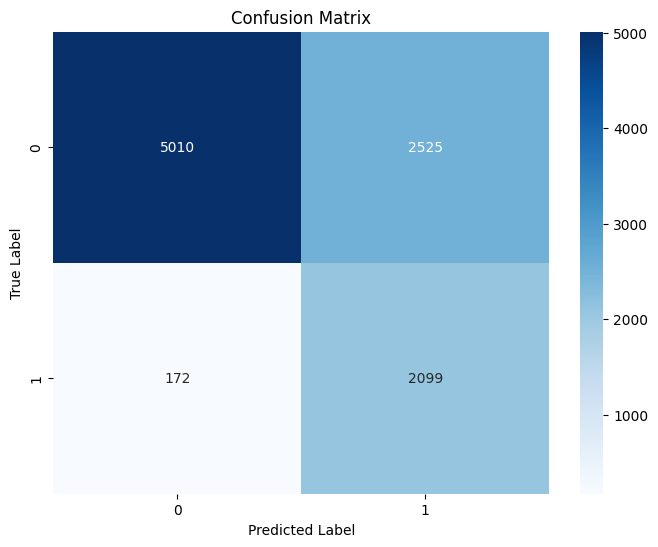

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Confusion Matrix to Pandas DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_df, annot=True, fmt=".0f", cmap="Blues")  # Change fmt="d" → fmt=".0f"

# Add Labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show plot
plt.show()
